In [178]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
import ipywidgets as widgets

import difi
import thor

import variant_orbits
import scheduling
import detection_probability
import magnitudes

In [3]:
plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

%config InlineBackend.figure_format = 'retina'

# Assess Algorithm Accuracy

### DIFI plus some small hacks

In [454]:
%%time
path="../neocp/neo/"

obs_dfs = [pd.read_hdf(path + f"filtered_visit_scores_{i:03d}.h5").sort_values("FieldMJD")[["FieldMJD", "night"]]
               for i in range(24)]
all_obs = pd.concat(obs_dfs)
all_obs["obs_id"] = np.arange(len(all_obs))
all_obs.reset_index(inplace=True)

print("Obs file done")

all_truths, findable_obs, summary = difi.analyzeObservations(
    observations=all_obs,
    classes=None,
    metric="nightly_linkages",
    column_mapping={"obs_id": "obs_id", "truth": "hex_id", "night": "night", "time": "FieldMJD"}
)

Obs file done
CPU times: user 4.23 s, sys: 82.9 ms, total: 4.32 s
Wall time: 4.31 s


In [510]:
%%time
findable_obs["night_detected"] = np.zeros(len(findable_obs)).astype(int)
findable_obs["actually_findable"] = np.repeat(True, len(findable_obs))

for ind, row in findable_obs.iterrows():
    obs_nights = np.unique(all_obs.loc[row["obs_ids"]]["night"].values)
    diff_nights = np.diff(obs_nights)
    window_sizes = np.array([sum(diff_nights[i:i + min_nights - 1])
                            for i in range(len(diff_nights) - min_nights + 2)])

    # record whether any are short enough
    if np.any(window_sizes <= detection_window):
        detection_obs_ind = np.arange(len(window_sizes))[window_sizes <= detection_window][0] + min_nights - 1
        findable_obs.loc[ind, "night_detected"] = obs_nights[detection_obs_ind]
    else:
        findable_obs.loc[ind, "night_detected"] = -1
        findable_obs.loc[ind, "actually_findable"] = False

CPU times: user 6.48 s, sys: 45.3 ms, total: 6.52 s
Wall time: 6.42 s


In [518]:
test = pd.read_hdf("findable_obs_mba.h5")

In [528]:
np.isin(unique_objs, test.index)

array([False, False, False, False, False, False, False, False, False,
       False, False, False])

In [526]:
test[test < 20].index

Index(['00418DF', '0041908', '0041951', '0041991', '00419A8', '00419D5',
       '00419F3', '00419F5', '00419FB', '0041A07',
       ...
       '0C4A442', '0C52CBD', '0C563D4', '0C56E4E', '0C6D8D9', '0C77FF8',
       '0C89343', '0CAFEA6', '0CB343E', '0CCB6B2'],
      dtype='object', name='hex_id', length=51813)

In [516]:
findable_obs[findable_obs["actually_findable"]].set_index("hex_id")["night_detected"]

hex_id
0000000     44
0000001    323
0000002    262
0000004     47
0000006    119
          ... 
00412FD    322
0041379    183
00413A5    245
004149E    295
0041800     90
Name: night_detected, Length: 7841, dtype: int64

In [517]:
findable_obs[findable_obs["actually_findable"]].set_index("hex_id")["night_detected"].to_hdf("neo_findable_obs_1yr.h5", key="df")

In [347]:
real_det_nights = findable_obs[findable_obs["actually_findable"]].set_index("hex_id")["night_detected"]

### Get data

In [500]:
unique_objs[~np.isin(unique_objs, already_ids)]

array(['000011D', '0002328', '0003BEC', '0008048', '000A292', '0013ED6',
       '001A197', '003B4E5'], dtype=object)

In [497]:
len(already_ids)

7795

In [505]:
concat_nights = range(360)

neo_probs = [None for _ in concat_nights]
neo_hexs = [None for _ in concat_nights]
neo_det_window = [None for _ in concat_nights]
neo_det_ever = [None for _ in concat_nights]
for i, night in enumerate(concat_nights):
    probs, unique_objs = np.load(f"latest_runs/neo_night{night}_probs.npy", allow_pickle=True)
    
    already_ids = real_det_nights[real_det_nights < night].index.values
    window_ids = real_det_nights[(real_det_nights >= night) &
                                 (real_det_nights < night + detection_window)].index.values
    ever_ids = real_det_nights[(real_det_nights >= night + detection_window)].index.values
    
    yet_to_be_found = ~np.isin(unique_objs, already_ids)
    unique_objs = unique_objs[yet_to_be_found]
    probs = probs[yet_to_be_found]
    
    neo_probs[i] = probs
    neo_hexs[i] = unique_objs
    neo_det_window[i] = np.isin(unique_objs, window_ids)
    neo_det_ever[i] = np.isin(unique_objs, ever_ids)
neo_probs = np.concatenate(neo_probs)
neo_hexs = np.concatenate(neo_hexs)
neo_det_window = np.concatenate(neo_det_window)
neo_det_ever = np.concatenate(neo_det_ever)

In [462]:
findable_obs[findable_obs["hex_id"] == "0007526"]

,hex_id,obs_ids,night_detected,actually_findable,obs_nights
5278,0007526,"[636, 690, 3629, 3754, 3784, 5710, 5736, 5743,...",15,True,"[0, 11, 15, 18, 19, 21, 22, 24, 27, 30, 366]"


### Calculate stats and plot

In [506]:
neo_det_window.astype(int).sum() / len(neo_det_window)

0.6060394658162248

In [507]:
def assess_algorithm_results(probs, hex_ids, det_window, det_ever, threshold=0.5, include_absolutes=True):
    correct_detectable = len(probs[(probs >= threshold) & det_window])
    correct_undetectable = len(probs[(probs < threshold) & ~det_window])
    incorrect_detectable = len(probs[(probs >= threshold) & ~det_window])
    incorrect_undetectable = len(probs[(probs < threshold) & det_window])

    c_u_eventually = len(probs[(probs < threshold) & ~det_window & det_ever])
    i_d_eventually = len(probs[(probs >= threshold) & ~det_window & det_ever])

#     c_u_days_until = np.median(findable_after_window[np.isin(findable_after_window["hex_id"],
#                                                              unique_objs[np.logical_and(probs < threshold, np.logical_not(will_be_detected))])]["night_detected"]).astype(int) - night_start - detection_window + 1
#     i_d_days_until = np.median(findable_after_window[np.isin(findable_after_window["hex_id"],
#                                                              unique_objs[np.logical_and(probs >= threshold, np.logical_not(will_be_detected))])]["night_detected"]).astype(int) - night_start - detection_window + 1

    print(f"Of the {len(probs)} objects, we classified")
    print(f"  {correct_detectable + correct_undetectable} correctly")
    print(f"    {correct_detectable} were detectable")
    print(f"    {correct_undetectable} were undetectable")
    print(f"  {incorrect_detectable + incorrect_undetectable} incorrectly")
    print(f"    {incorrect_detectable} were detectable")
    print(f"    {incorrect_undetectable} were undetectable")
    print(f"Overall success rate: {100 * (correct_detectable + correct_undetectable) / len(probs):1.2f}%")
    
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [1, 2]})

    axes[0].set_title(f"NEOs", fontsize=1.1*fs)

    axes[0].axvline(0.5, color="white", linestyle="dotted")
    axes[0].axhline(0.5, color="white", linestyle="dotted")

    axes[0].annotate("Detectable", xy=(0.25, -0.02), xycoords="axes fraction", ha="center", va="top", fontsize=0.7*fs)
    axes[0].annotate("Undetectable", xy=(0.75, -0.02), xycoords="axes fraction", ha="center", va="top", fontsize=0.7*fs)

    axes[0].annotate("Undetectable", xy=(-0.02, 0.25), xycoords="axes fraction", ha="right", va="center", fontsize=0.7*fs, rotation=90)
    axes[0].annotate("Detectable", xy=(-0.02, 0.75), xycoords="axes fraction", ha="right", va="center", fontsize=0.7*fs, rotation=90)

    axes[0].annotate(incorrect_undetectable, xy=(0.25, 0.25), ha="center", va="center", fontsize=1.5*fs)
    axes[0].annotate("Excess NEOCP", xy=(0.25, 0.15), ha="center", va="center", fontsize=0.6*fs)
    axes[0].annotate(correct_undetectable, xy=(0.75, 0.25), ha="center", va="center", fontsize=1.5*fs)
    axes[0].annotate(f"{c_u_eventually} found after window", xy=(0.98, 0.02), ha="right", va="bottom", fontsize=0.4*fs)
    axes[0].annotate(incorrect_detectable, xy=(0.75, 0.75), ha="center", va="center", fontsize=1.5*fs)
    axes[0].annotate("Lost objects", xy=(0.75, 0.65), ha="center", va="center", fontsize=0.6*fs)
    axes[0].annotate(f"{i_d_eventually} found after window", xy=(0.98, 0.98), ha="right", va="top", fontsize=0.4*fs)
    axes[0].annotate(correct_detectable, xy=(0.25, 0.75), ha="center", va="center", fontsize=1.5*fs)

    axes[0].axvspan(0, 0.5, 0, 0.5, color=plt.cm.Reds(incorrect_undetectable / len(probs)))
    axes[0].axvspan(0.5, 1, 0, 0.5, color=plt.cm.Greens(correct_undetectable / len(probs)))
    axes[0].axvspan(0, 0.5, 0.5, 1, color=plt.cm.Greens(correct_detectable / len(probs)))
    axes[0].axvspan(0.5, 1, 0.5, 1, color=plt.cm.Reds(incorrect_detectable / len(probs)))

    axes[0].set_xlabel("\nTruth")
    axes[0].set_ylabel("Prediction\n")

    axes[0].set_xticks([])
    axes[0].set_yticks([])

    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(0, 1)

    bins = np.linspace(0, 1, 50)
    
    if include_absolutes:
        axes[1].hist(probs[det_window], label="Detected", bins=bins)
        axes[1].hist(probs[~det_window], alpha=0.6, label="Not be detected", bins=bins)
    else:
        axes[1].hist(probs[det_window & (probs != 1.0) & (probs != 0.0)], label="Detected", bins=bins)
        axes[1].hist(probs[~det_window & (probs != 1.0) & (probs != 0.0)], alpha=0.6, label="Not be detected", bins=bins)
    axes[1].axvline(threshold, color="tab:red", linestyle="--", lw=3)

    axes[1].set_xlabel("Probability of detection")
    axes[1].set_ylabel("Number of objects")
    axes[1].legend(fontsize=0.7*fs)

    # plt.savefig("../scratch/fig.png")

    plt.show()

Of the 10034 objects, we classified
  7353 correctly
    5424 were detectable
    1929 were undetectable
  2681 incorrectly
    2024 were detectable
    657 were undetectable
Overall success rate: 73.28%


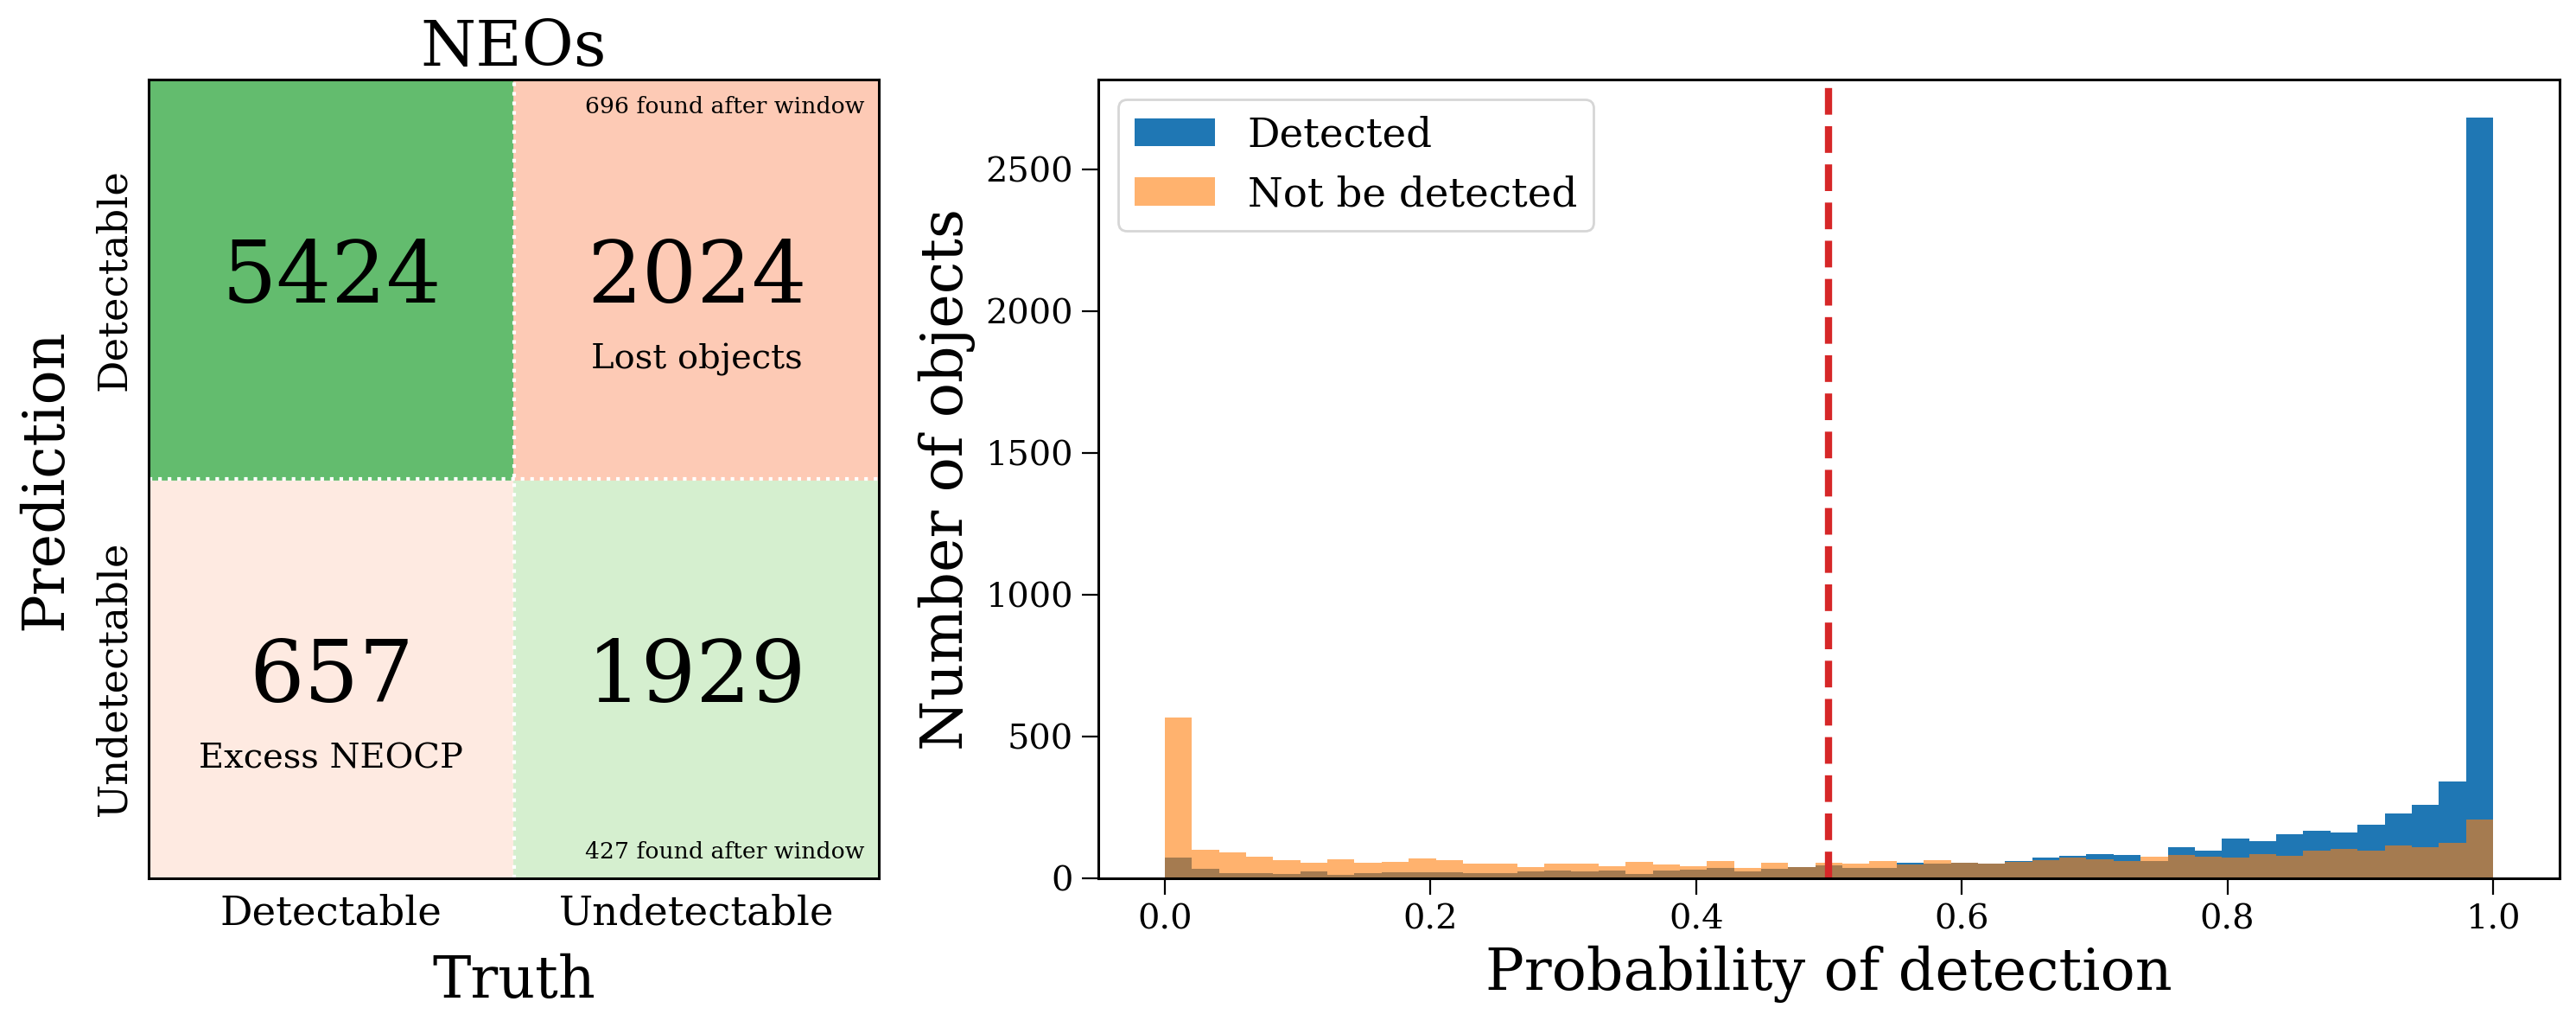

In [509]:
assess_algorithm_results(neo_probs, neo_hexs, neo_det_window, neo_det_ever, threshold=0.5)

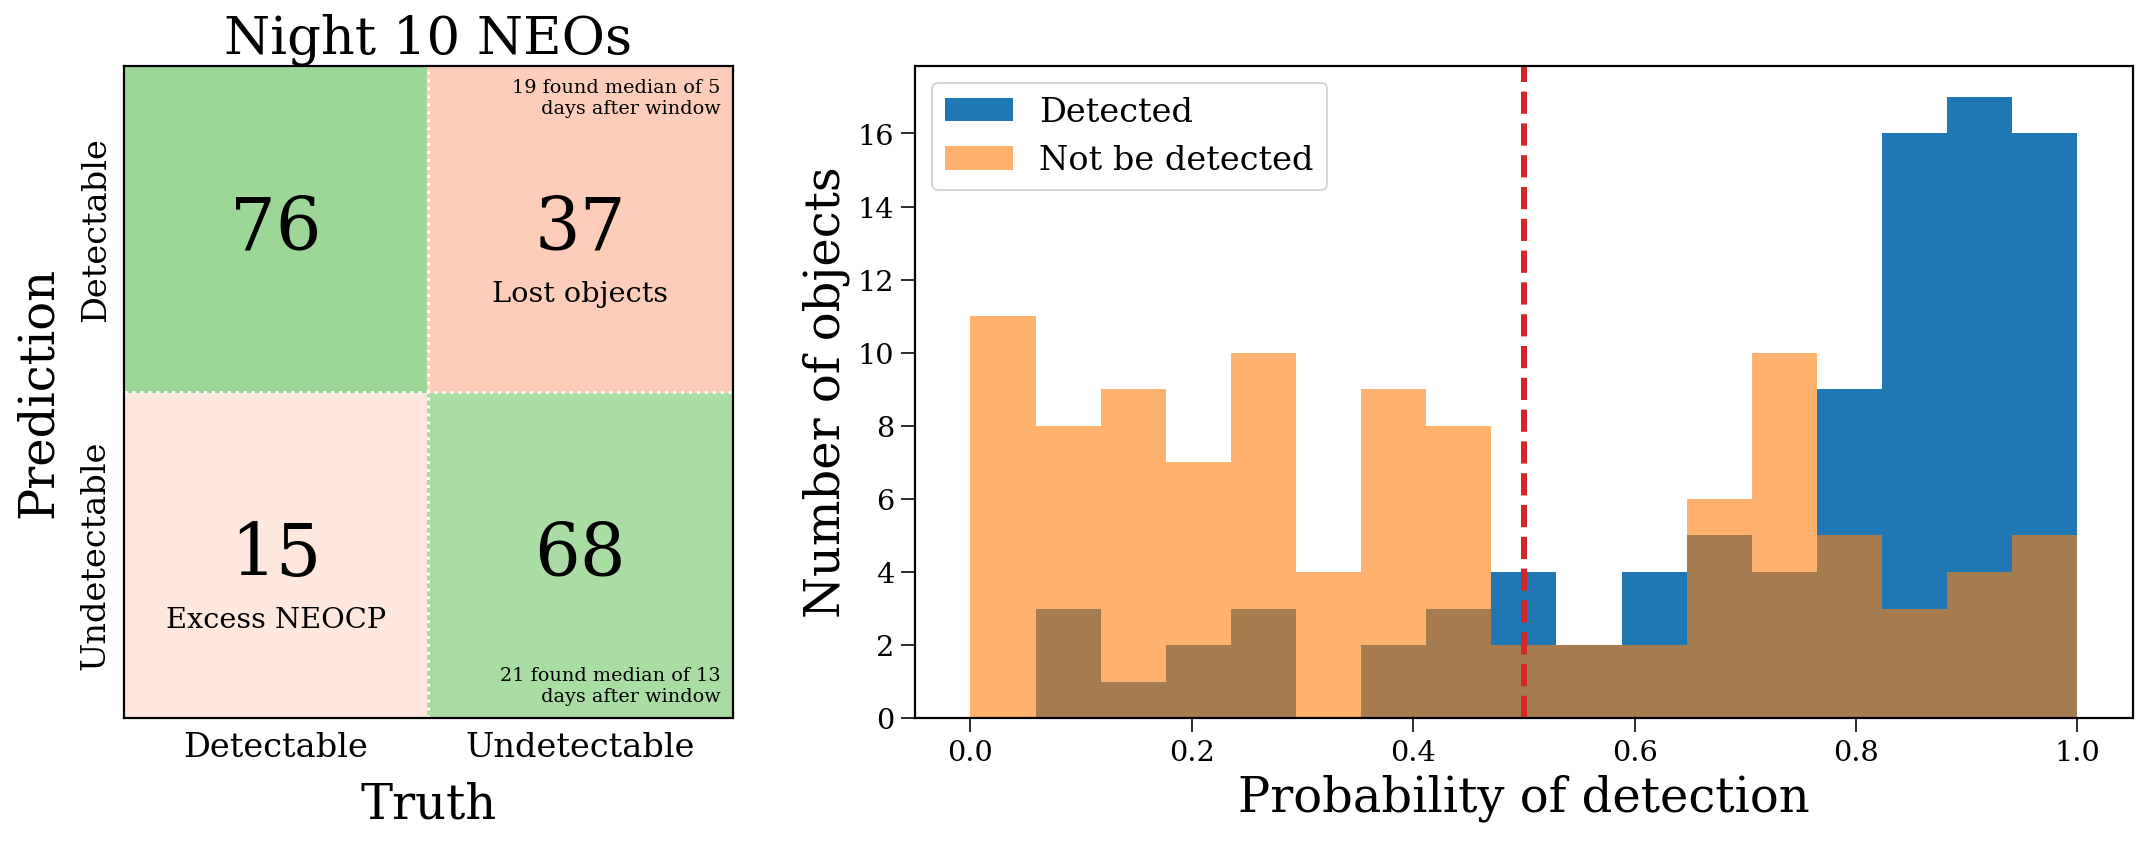

# Investigate outliers

In [404]:
from importlib import reload
reload(scheduling)
reload(variant_orbits)
reload(detection_probability)
reload(magnitudes)

<module 'magnitudes' from '/data/epyc/projects/hybrid-sso-catalogs/lsst_detection_probability/magnitudes.py'>

In [43]:
unique_objs[np.logical_and(probs < 0.3, will_be_detected)]

Index(['00022F2', '0035981', '0009CC0', '000C2E2', '000F110', '0011372',
       '0016AFE', '001850E'],
      dtype='object', name='hex_id')

In [44]:
unique_objs[np.logical_and(probs >= 0.65, np.logical_not(will_be_detected))]

Index(['00000A7', '0001841', '00015B6', '000506E', '002A649', '003382A',
       '000A1EE', '0015C63'],
      dtype='object', name='hex_id')

In [195]:
list(range(night_start - detection_window + 1, night_start))

[-14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]

In [193]:
night_start = 0
start_file = find_first_file(list(range(night_start - detection_window + 1, night_start)))
end_file = find_last_file(night_start)
print(start_file, end_file)

None 0


In [290]:
obj_type= "neo"

In [403]:
prior_obs_nights["0000220"]

[1]

In [423]:
night_start = 18

obj_type= "neo"
path = f"/epyc/projects/hybrid-sso-catalogs/neocp/{obj_type}/"

# create a list of nights in the detection window and get schedule for them
night_list = list(range(night_start, night_start + detection_window))

if schedule_type == "predicted":
    full_schedule = scheduling.get_LSST_schedule(night=night_start, schedule_type=schedule_type)
else:
    full_schedule = scheduling.get_LSST_schedule(night=(night_start, night_start + detection_window - 1),
                                      schedule_type=schedule_type)

# offset the schedule by one row and re-merge to get the previous night column
shifted = full_schedule.shift()
full_schedule["previousNight"] = shifted["night"]

# calculate the length of each night in days
night_lengths = np.zeros(detection_window)
for i, night in enumerate(night_list):
    mask = full_schedule["night"] == night

    # ignore nights that have no observations (bad weather/downtime)
    if not full_schedule[mask].empty:
        night_lengths[i] = full_schedule[mask].iloc[-1]["observationStartMJD"]\
            - full_schedule[mask].iloc[0]["observationStartMJD"]

# get the first/last visit from each night
night_transition = full_schedule["night"] != full_schedule["previousNight"]
first_visit_times = full_schedule[night_transition]["observationStartMJD"].values

last_times_ind = np.array(list(full_schedule[night_transition].index[1:]) + [len(full_schedule)]) - 1
last_visit_times = full_schedule.loc[last_times_ind]["observationStartMJD"].values

print("Schedule is loaded in and ready!")

# work out which visit files contain the observations
start_file = find_first_file(list(range(night_start - detection_window + 1, night_start)))
end_file = find_last_file(night_list)

# either open one file or concatenate a bunch of them
if start_file == end_file or start_file is None:
    all_obs = pd.read_hdf(path + f"filtered_visit_scores_{end_file:03d}.h5").sort_values("FieldMJD")
else:
    obs_dfs = [pd.read_hdf(path + f"filtered_visit_scores_{i:03d}.h5").sort_values("FieldMJD")
                for i in range(start_file, end_file + 1)]
    all_obs = pd.concat(obs_dfs)

print("Observation files read in")

# get the sorted observations for the start night (that have digest2 > 65 and at least 3 observations)
sorted_obs = all_obs[(all_obs["night"] == night_start)
                     & (all_obs["scores"] >= 65)
                     & (all_obs["n_obs"] >= 3)].sort_values(["ObjID", "FieldMJD"])
unique_objs = sorted_obs.index.unique()

# get the prior observations that occurred in the past detection window that could possibly contribute
all_obs = all_obs[(all_obs["night"] > night_start - detection_window) & (all_obs["night"] < night_start)]
prior_obs = all_obs[all_obs.index.isin(unique_objs)]

print("Masks applied to observation files")

# create a (default)dict of the nights on which observations occurred
if prior_obs.empty:
    prior_obs_nights = defaultdict(list)
else:
    dd = defaultdict(list)
    s = prior_obs.groupby("hex_id").apply(lambda x: list(x["night"].unique()))
    prior_obs_nights = s.to_dict(into=dd)

    # identify objects that would not already have been detected before this night
    already_found_ids = s[s.apply(len) >= min_nights].index

    # reduce the original observations to include only these
    sorted_obs = sorted_obs[~sorted_obs.index.isin(already_found_ids)].sort_values(["ObjID", "FieldMJD"])
    unique_objs = sorted_obs.index.unique()

print("Everything is prepped and ready for probability calculations - Time to create some offspring")

Schedule is loaded in and ready!
Observation files read in
Masks applied to observation files
Everything is prepped and ready for probability calculations - Time to create some offspring


In [ ]:
reload(detection_probability)

In [426]:
findable_obs[findable_obs["hex_id"] == "0007526"]

,hex_id,obs_ids,night_detected,actually_findable,obs_nights
5278,0007526,"[636, 690, 3629, 3754, 3784, 5710, 5736, 5743,...",15,True,"[0, 11, 15, 18, 19, 21, 22, 24, 27, 30, 366]"


In [424]:
detection_probability.probability_from_id("0007526", sorted_obs,
                                                 np.logspace(-1, 1, 51) * u.AU,
                                                 np.linspace(-50, 10, 21) * u.km / u.s, prior_obs_nights,
                                                 first_visit_times, full_schedule,
                                                 night_lengths, night_list)

[11, 15] [18]
[11, 15] [18]
[11, 15] [18]
[11, 15] [18 22]
[11, 15] [18 22]
[11, 15] [18]
[11, 15] [18]
[11, 15] [18 22 23]
[11, 15] [18 22 23]
[11, 15] [18 21 22 23]
[11, 15] [18 21 22 23]
[11, 15] [18 21 22 23]
[11, 15] [18 22 23]
[11, 15] [18]
[11, 15] [18 22 23]
[11, 15] [18 22 23]
[11, 15] [18 22 23]
[11, 15] [18 22 23 27]
[11, 15] [18 23 27]
[11, 15] [18 22 23 27]
[11, 15] [18 23 27]
[11, 15] [18 21]
[11, 15] [18 21]
[11, 15] [18]
[11, 15] [18]
[11, 15] [18]
[11, 15] [18 21]
[11, 15] [18 22]
[11, 15] [18]
[11, 15] [18]
[11, 15] [18]
[11, 15] [18 22 23]
[11, 15] [18 22 23]
[11, 15] [18 21 22 23]
[11, 15] [18 21 22 23]
[11, 15] [18 22]
[11, 15] [18 21 23]
[11, 15] [18 22 23]
[11, 15] [18 22 23]
[11, 15] [18 22 23]
[11, 15] [18 22 23]
[11, 15] [18 22 23 27]
[11, 15] [18 23 27]
[11, 15] [18 22 27]
[11, 15] [18 22 23 27]
[11, 15] [18 21]
[11, 15] [18 22]
[11, 15] [18]
[11, 15] [18]
[11, 15] [18 21]
[11, 15] [18]
[11, 15] [18 22]
[11, 15] [18]
[11, 15] [18]
[11, 15] [18 22 23]
[11, 15]

1.0

In [11]:
s3m_cart = pd.read_hdf("../catalogues/s3m_cart.h5")
s3m_cart["hex_id"] = np.array(['{:07X}'.format(num) for num in np.arange(len(s3m_cart.index.values))])

In [141]:
hex_id = "000D958"

In [296]:
from importlib import reload
reload(scheduling)
reload(variant_orbits)
reload(detection_probability)
reload(magnitudes)

<module 'magnitudes' from '/data/epyc/projects/hybrid-sso-catalogs/lsst_detection_probability/magnitudes.py'>

In [155]:
distances = np.logspace(-1, 1, 51) * u.AU
radial_velocities = np.linspace(-50, 10, 21) * u.km / u.s

rows = sorted_obs.loc[hex_id]
reachable_schedule = detection_probability.get_reachable_schedule(rows, first_visit_times, night_list,
                                            night_lengths, full_schedule)

v_mags = [magnitudes.convert_colour_mags(r["MaginFilter"],
                              in_colour=r["filter"], out_colour="V") for _, r in rows.iterrows()]
apparent_mag = np.mean(v_mags)

print(hex_id, rows.iloc[0]["FieldMJD"])

# get the orbits for the entire reachable schedule with the grid of distances and RVs
ra=rows.iloc[0]["AstRA(deg)"] * u.deg
dec=rows.iloc[0]["AstDec(deg)"] * u.deg
ra_end=rows.iloc[-1]["AstRA(deg)"] * u.deg
dec_end=rows.iloc[-1]["AstDec(deg)"] * u.deg
delta_t=(rows.iloc[-1]["FieldMJD"] - rows.iloc[0]["FieldMJD"]) * u.day
obstime=Time(rows.iloc[0]["FieldMJD"], format="mjd")
distances=distances
radial_velocities=radial_velocities
apparent_mag=apparent_mag
eph_times=Time(reachable_schedule["observationStartMJD"].values, format="mjd")
only_neos=True
num_jobs=1

59664.013807512965
ecl.obstime.mjd 59664.013807512965
lt [0.00577572] 59664.013807512965 [145.06992429] deg
000D958 59664.013807512965


In [157]:

from astropy.coordinates import SkyCoord, EarthLocation, get_sun

In [163]:

from thor.constants import Constants

In [164]:
coords="heliocentriceclipticiau76"
location="Gemini South"
obs_code="I11"
sigma_ra=0.1 * u.arcsecond
sigma_dec=0.1 * u.arcsecond

# create a grid from the distances and radial velocities
D, RV = np.meshgrid(distances, radial_velocities)
size = len(distances) * len(radial_velocities)

# use astropy to get information based on a site name
obs_loc = EarthLocation.of_site(location)

# need a list with units rather than list of things each with units
obsgeoloc = [x.to(u.m).value for x in obs_loc.geocentric] * u.m

# get the observer position in cartesian GCRS coordinates for THOR
observer_position = SkyCoord(x=obsgeoloc[0],
                             y=obsgeoloc[1],
                             z=obsgeoloc[2],
                             obstime=obstime,
                             frame="gcrs",
                             representation_type="cartesian").transform_to(coords).cartesian.xyz
observer_positions = np.tile(observer_position.to(u.AU).value, (size, 1))

# if proper motions are not provided
# add some dispersion to the ra/dec's with the given sigmas (or just repeat if not are given)
if sigma_ra.value == 0.0:
    ra = np.repeat(ra.value, repeats=size) * ra.unit
    ra_end = np.repeat(ra_end.value, repeats=size) * ra_end.unit
else:
    ra = np.random.normal(ra.value, scale=sigma_ra.to(ra.unit).value, size=size) * ra.unit
    ra_end = np.random.normal(ra_end.value, scale=sigma_ra.to(ra_end.unit).value, size=size) * ra_end.unit

if sigma_dec.value == 0.0:
    dec = np.repeat(dec.value, repeats=size) * dec.unit
    dec_end = np.repeat(dec_end.value, repeats=size) * dec_end.unit
else:
    dec = np.random.normal(dec.value, scale=sigma_dec.to(dec.unit).value, size=size) * dec.unit
    dec_end = np.random.normal(dec_end.value, scale=sigma_dec.to(dec_end.unit).value, size=size) * dec_end.unit

# convert them to Skycoords
start = SkyCoord(ra=ra, dec=dec, frame="icrs")
end = SkyCoord(ra=ra_end, dec=dec_end, frame="icrs")

# calculate the offset in ra/dec and convert to a proper motion
delta_ra_cosdec, delta_dec = start.spherical_offsets_to(end)
pm_ra_cosdec, pm_dec = delta_ra_cosdec / delta_t, delta_dec / delta_t

# put it all together into a single astropy SkyCoord in GCRS (using loc/time from above)
coord = SkyCoord(ra=ra,
                 dec=dec,
                 pm_ra_cosdec=pm_ra_cosdec,
                 pm_dec=pm_dec,
                 distance=D.ravel(),
                 radial_velocity=RV.ravel(),
                 frame="gcrs",
                 obsgeoloc=obsgeoloc,
                 obstime=obstime)

# convert to ecliptic
ecl = coord.transform_to(coords)

print("ecl.obstime.mjd", ecl.obstime.mjd)

# translate astropy into what THOR wants
orbits = np.atleast_2d(np.concatenate((ecl.cartesian.xyz.to(u.AU).value,
                                       ecl.velocity.d_xyz.to(u.AU / u.day).value))).T
t0 = np.repeat(ecl.obstime.mjd, size)

# use THOR to account for light travel time
corrected_orbits, lt = thor.addLightTime(orbits=orbits, t0=t0, observer_positions=observer_positions,
                                         lt_tol=1e-10, mu=Constants.MU, max_iter=1000, tol=1e-15)
corrected_t0 = t0 - lt

print("lt", lt, obstime, ra)

ecl.obstime.mjd 59664.013807512965
lt [0.00057767 0.0006334  0.00069451 ...        nan        nan        nan] 59664.013807512965 [145.07000452 145.06989093 145.06987599 ... 145.06995633 145.06991065
 145.06992333] deg


In [188]:
orbits[~np.isnan(lt)]

array([[-1.07071293e+00, -5.12923814e-02, -5.23585555e-02,
         3.34200501e-02, -6.05651632e-03,  1.53626155e-02],
       [-1.07815947e+00, -4.78133207e-02, -5.74108403e-02,
         3.43669782e-02, -3.98194522e-03,  1.53955160e-02],
       [-1.08632463e+00, -4.39985488e-02, -6.29502331e-02,
         3.54185029e-02, -1.69844843e-03,  1.54181082e-02],
       ...,
       [-5.43508410e+00,  1.98770069e+00, -3.01327122e+00,
         5.66893089e-01,  1.22560155e+00,  1.10148265e-02],
       [-5.86358907e+00,  2.18789134e+00, -3.30400381e+00,
         6.21532682e-01,  1.34551187e+00,  1.30496936e-02],
       [-6.33345375e+00,  2.40739914e+00, -3.62275662e+00,
         6.82228905e-01,  1.47651119e+00,  1.37912515e-02]])

In [185]:
t0[np.isnan(lt)]

array([59664.01380751, 59664.01380751, 59664.01380751, 59664.01380751,
       59664.01380751, 59664.01380751, 59664.01380751, 59664.01380751,
       59664.01380751, 59664.01380751, 59664.01380751, 59664.01380751,
       59664.01380751, 59664.01380751, 59664.01380751, 59664.01380751,
       59664.01380751, 59664.01380751, 59664.01380751, 59664.01380751,
       59664.01380751, 59664.01380751, 59664.01380751, 59664.01380751,
       59664.01380751, 59664.01380751, 59664.01380751, 59664.01380751,
       59664.01380751, 59664.01380751, 59664.01380751, 59664.01380751,
       59664.01380751, 59664.01380751, 59664.01380751, 59664.01380751,
       59664.01380751, 59664.01380751, 59664.01380751, 59664.01380751,
       59664.01380751, 59664.01380751, 59664.01380751, 59664.01380751,
       59664.01380751, 59664.01380751, 59664.01380751, 59664.01380751,
       59664.01380751, 59664.01380751, 59664.01380751, 59664.01380751,
       59664.01380751, 59664.01380751, 59664.01380751, 59664.01380751,
      

In [170]:
radial_velocities

<Quantity [-50., -47., -44., -41., -38., -35., -32., -29., -26., -23.,
           -20., -17., -14., -11.,  -8.,  -5.,  -2.,   1.,   4.,   7.,
            10.] km / s>

In [176]:
1 - (1.3 / 11)

0.8818181818181818

In [174]:
distances

<Quantity [ 0.1       ,  0.10964782,  0.12022644,  0.13182567,  0.14454398,
            0.15848932,  0.17378008,  0.19054607,  0.20892961,  0.22908677,
            0.25118864,  0.27542287,  0.30199517,  0.33113112,  0.36307805,
            0.39810717,  0.43651583,  0.47863009,  0.52480746,  0.57543994,
            0.63095734,  0.69183097,  0.75857758,  0.83176377,  0.91201084,
            1.        ,  1.0964782 ,  1.20226443,  1.31825674,  1.44543977,
            1.58489319,  1.73780083,  1.90546072,  2.08929613,  2.29086765,
            2.51188643,  2.7542287 ,  3.01995172,  3.31131121,  3.63078055,
            3.98107171,  4.36515832,  4.78630092,  5.2480746 ,  5.75439937,
            6.30957344,  6.91830971,  7.58577575,  8.31763771,  9.12010839,
           10.        ] AU>

In [173]:
np.unique(D.ravel()[np.isnan(lt)])

<Quantity [ 7.58577575,  8.31763771,  9.12010839, 10.        ] AU>

In [293]:
%%time
prob, joined_table = detection_probability.probability_from_id(hex_id, sorted_obs,
                                                 np.logspace(-1, 1, 51) * u.AU,
                                                 np.linspace(-50, 10, 21) * u.km / u.s,
                                                 first_visit_times, full_schedule,
                                                 night_lengths, night_list)

59812.97165056028
ecl.obstime.mjd 59812.97165056028
lt [0.00577594] 59812.97165056028 [249.4704038] deg
00337FE 59812.97165056028
59812.97165056028
ecl.obstime.mjd 59812.97165056028
lt [0.00057769 0.00063343 0.00069454 ... 0.048041   0.05267592 0.05775802] 59812.97165056028 [249.47039808 249.47050128 249.47043141 ... 249.47041829 249.47043188
 249.47042361] deg
CPU times: user 6.75 s, sys: 103 ms, total: 6.85 s
Wall time: 6.84 s


In [92]:
%%time
reachable_schedule = detection_probability.get_reachable_schedule(sorted_obs.loc[hex_id], first_visit_times,
                                                                  night_list, night_lengths, full_schedule)

CPU times: user 231 ms, sys: 4.94 s, total: 5.17 s
Wall time: 6.02 s


In [93]:
%%time
ephemerides, truth = detection_probability.first_last_pos_from_id(hex_id, sorted_obs, s3m_cart,
                                                             np.logspace(-1, 1, 51) * u.AU,
                                                             np.linspace(-50, 10, 21) * u.km / u.s,
                                                             first_visit_times, last_visit_times)

CPU times: user 1.33 s, sys: 10.6 s, total: 12 s
Wall time: 14.4 s


In [94]:
reload(detection_probability)
interact(detection_probability.plot_LSST_schedule_with_orbits,
         schedule=fixed(full_schedule), reachable_schedule=fixed(reachable_schedule),
         ephemerides=fixed(ephemerides), truth=fixed(truth), joined_table=fixed(joined_table),
         night=widgets.IntSlider(min=10, max=24, step=1, value=10, continuous_update=False),
         hex_id=fixed(hex_id),
         colour_by=widgets.Dropdown(
            value='distance',
            options=['distance', 'orbit'],
            description='Colour by:',
            ensure_option=True,
            disabled=False),
         lims=widgets.Dropdown(
            value='full_schedule',
            options=['orbits', 'full_schedule', 'schedule', 'reachable'],
            description='Axes limits:',
            ensure_option=True,
            disabled=False),
         filter_mask=widgets.Dropdown(
            value='all',
            options=['all', 'u', 'g', 'r', 'i', 'z', 'y'],
            description='Filter:',
            ensure_option=True,
            disabled=False),
         field_radius=fixed(2.1),
         s=widgets.IntSlider(min=1, max=25, step=1, value=15, continuous_update=False),
         show_mag_labels=widgets.ToggleButton(
            value=False,
            description='Show mag lims',
            disabled=False,
            button_style='success', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Whether to show limiting magnitudes for each field',
            icon='check'),
         fig=fixed(None), ax=fixed(None),show=fixed(True), cbar=fixed(True), ax_labels=fixed(True)
        )

interactive(children=(IntSlider(value=10, continuous_update=False, description='night', max=24, min=10), Dropd…

<function detection_probability.plot_LSST_schedule_with_orbits(schedule, reachable_schedule, ephemerides, joined_table, truth, night, hex_id, colour_by='distance', lims='full_schedule', field_radius=2.1, s=10, filter_mask='all', show_mag_labels=False, fig=None, ax=None, show=True, ax_labels=True, cbar=True)>

# Are particular orbits harder to predict (I guess yes)

Update: I guessed wrong

In [93]:
true_params = s3m_cart[np.isin(s3m_cart["hex_id"], unique_objs)]

In [94]:
orbits_class = thor.Orbits(orbits=np.atleast_2d(np.concatenate(([true_params["x"], true_params["y"], true_params["z"]],
                                                                [true_params["vx"], true_params["vy"], true_params["vz"]]))).T,
                           epochs=Time(true_params["t_0"], format="mjd"))

In [95]:
orbits_class.keplerian

array([[1.63591956e+00, 4.24185921e-01, 4.57895783e+01, 3.43777755e+02,
        6.49956977e+01, 1.54872825e+02],
       [2.01117210e+00, 6.40305581e-01, 5.27938423e+01, 3.54874150e+02,
        2.33728656e+01, 2.21513638e+02],
       [1.46604986e+00, 5.28881346e-01, 2.65098657e+01, 2.50039142e+02,
        1.11672186e+02, 1.78288579e+02],
       ...,
       [1.60510044e+00, 2.95866783e-01, 2.45988084e+01, 1.92490199e+02,
        9.37351683e-01, 3.56766083e+02],
       [1.98769282e+00, 7.00609554e-01, 2.62840510e+01, 3.43548340e+02,
        8.28409374e+01, 3.58931646e+02],
       [1.96717633e+00, 7.80163838e-01, 1.65028245e+01, 1.76927663e+02,
        1.08970240e+02, 2.87917001e+02]])

In [96]:
q = orbits_class.keplerian[:, 0] * (1 - orbits_class.keplerian[:, 1])

In [97]:
got_it_right = (probs > 0.5) == will_be_detected

NameError: name 'probs' is not defined

In [291]:
colours = ["tab:green" if yup else "tab:red" for yup in got_it_right]

In [292]:
true_params

,id,x,y,z,vx,vy,vz,coords,t_0,time_type,H,g,hex_id
S000002Ma,167.0,-1.667047,-0.858776,-1.326359,0.004811,-0.005856,-0.004398,1.0,54466.0,3.0,15.849,0.15,00000A7
S000005Aa,335.0,-2.670562,-0.879820,-1.468497,0.004954,-0.002611,-0.002842,1.0,54466.0,3.0,16.713,0.15,000014F
S000009Ea,579.0,-2.034149,-0.117710,-0.933631,-0.000217,-0.007789,0.001225,1.0,54466.0,3.0,17.390,0.15,0000243
S00000fua,932.0,-0.816946,3.114705,-0.379257,-0.006347,0.001696,-0.000940,1.0,54466.0,3.0,17.977,0.15,00003A4
S00000jsa,1175.0,-1.428541,-0.739073,-1.059737,0.010892,-0.002073,0.003008,1.0,54466.0,3.0,18.259,0.15,0000497
...,...,...,...,...,...,...,...,...,...,...,...,...,...
S00015ySa,252642.0,-1.241447,0.363831,-0.070625,-0.000347,-0.015706,-0.002807,1.0,54466.0,3.0,24.924,0.15,003DAE2
S00015RKa,253781.0,2.664565,-1.647325,0.364562,0.003198,0.006329,-0.000184,1.0,54466.0,3.0,24.930,0.15,003DF55
S00017xaa,260048.0,-1.120751,-0.151135,-0.043414,0.002398,-0.016566,0.007642,1.0,54466.0,3.0,24.960,0.15,003F7D0
S0001805a,261795.0,0.300718,0.449375,0.254915,-0.025643,0.013277,0.002702,1.0,54466.0,3.0,24.968,0.15,003FEA3


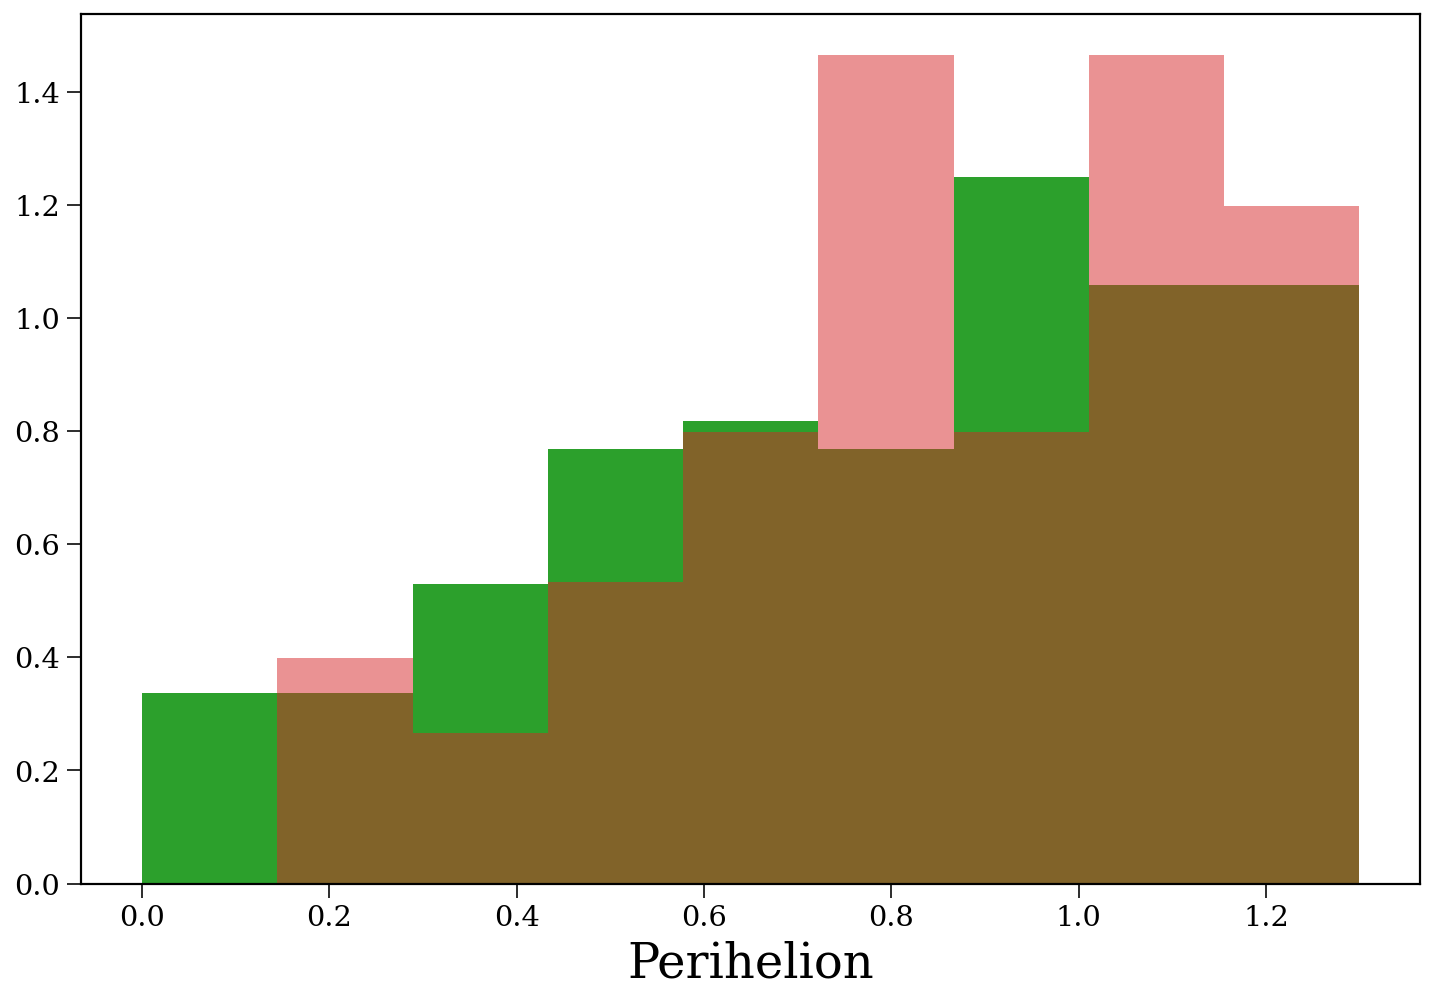

In [294]:
plt.hist(q[got_it_right], bins=np.linspace(0, 1.3, 10), density=True, cumulative=False, color="tab:green")
plt.hist(q[np.logical_not(got_it_right)], bins=np.linspace(0, 1.3, 10), density=True, cumulative=False, alpha=0.5, color="tab:red")
plt.xlabel("Perihelion")
plt.show()

In [78]:
sc = SkyCoord(x=true_params["x"] * u.AU, y=true_params["y"] * u.AU, z=true_params["z"] * u.AU,
         v_x=true_params["vx"] * u.AU / u.day, v_y=true_params["vy"] * u.AU / u.day, v_z=true_params["vz"] * u.AU / u.day,
         frame="heliocentriceclipticiau76", representation_type="cartesian")

In [80]:
sc.transform_to("icrs").dec

<Latitude [-4.26195977e+01, -3.22914713e+01, -2.37231747e+01,
            1.59378369e+01, -4.09777900e+01,  3.78583545e+01,
           -1.06836469e+01, -2.98440073e+01,  5.16319752e-01,
           -3.87691675e+01, -3.50857780e+00,  3.82140340e+00,
           -5.20693997e+00, -3.95406799e+01,  4.33931175e+01,
           -9.75720779e+00, -5.21721060e+01, -5.89266611e+01,
           -2.24026068e+01, -4.80962996e+01, -2.81064499e+01,
            2.93205129e+01,  2.22192286e+01,  2.45959909e+00,
           -1.39388002e+01,  3.78021236e+01, -7.45805364e+00,
           -1.11743370e+00, -4.19530486e+01, -4.92075884e+01,
           -5.41168944e+01,  3.54369955e+00, -1.97183381e+01,
            2.78456311e+01, -2.73656530e+01,  1.96673108e+01,
            2.10235692e+01,  1.14507319e+01, -3.18970816e+01,
           -1.33822790e+01,  2.04241291e+01, -2.48786846e+01,
           -4.52631713e+00,  3.23004632e+01, -2.09499206e+01,
           -2.33388521e+01,  1.84905706e+01,  1.88503133e+01,
        

In [300]:
np.median(true_params["H"][got_it_right])

22.271

In [298]:
np.median(true_params["H"][~got_it_right])

22.8455

In [301]:
true_params

,id,x,y,z,vx,vy,vz,coords,t_0,time_type,H,g,hex_id
S000002Ma,167.0,-1.667047,-0.858776,-1.326359,0.004811,-0.005856,-0.004398,1.0,54466.0,3.0,15.849,0.15,00000A7
S000005Aa,335.0,-2.670562,-0.879820,-1.468497,0.004954,-0.002611,-0.002842,1.0,54466.0,3.0,16.713,0.15,000014F
S000009Ea,579.0,-2.034149,-0.117710,-0.933631,-0.000217,-0.007789,0.001225,1.0,54466.0,3.0,17.390,0.15,0000243
S00000fua,932.0,-0.816946,3.114705,-0.379257,-0.006347,0.001696,-0.000940,1.0,54466.0,3.0,17.977,0.15,00003A4
S00000jsa,1175.0,-1.428541,-0.739073,-1.059737,0.010892,-0.002073,0.003008,1.0,54466.0,3.0,18.259,0.15,0000497
...,...,...,...,...,...,...,...,...,...,...,...,...,...
S00015ySa,252642.0,-1.241447,0.363831,-0.070625,-0.000347,-0.015706,-0.002807,1.0,54466.0,3.0,24.924,0.15,003DAE2
S00015RKa,253781.0,2.664565,-1.647325,0.364562,0.003198,0.006329,-0.000184,1.0,54466.0,3.0,24.930,0.15,003DF55
S00017xaa,260048.0,-1.120751,-0.151135,-0.043414,0.002398,-0.016566,0.007642,1.0,54466.0,3.0,24.960,0.15,003F7D0
S0001805a,261795.0,0.300718,0.449375,0.254915,-0.025643,0.013277,0.002702,1.0,54466.0,3.0,24.968,0.15,003FEA3


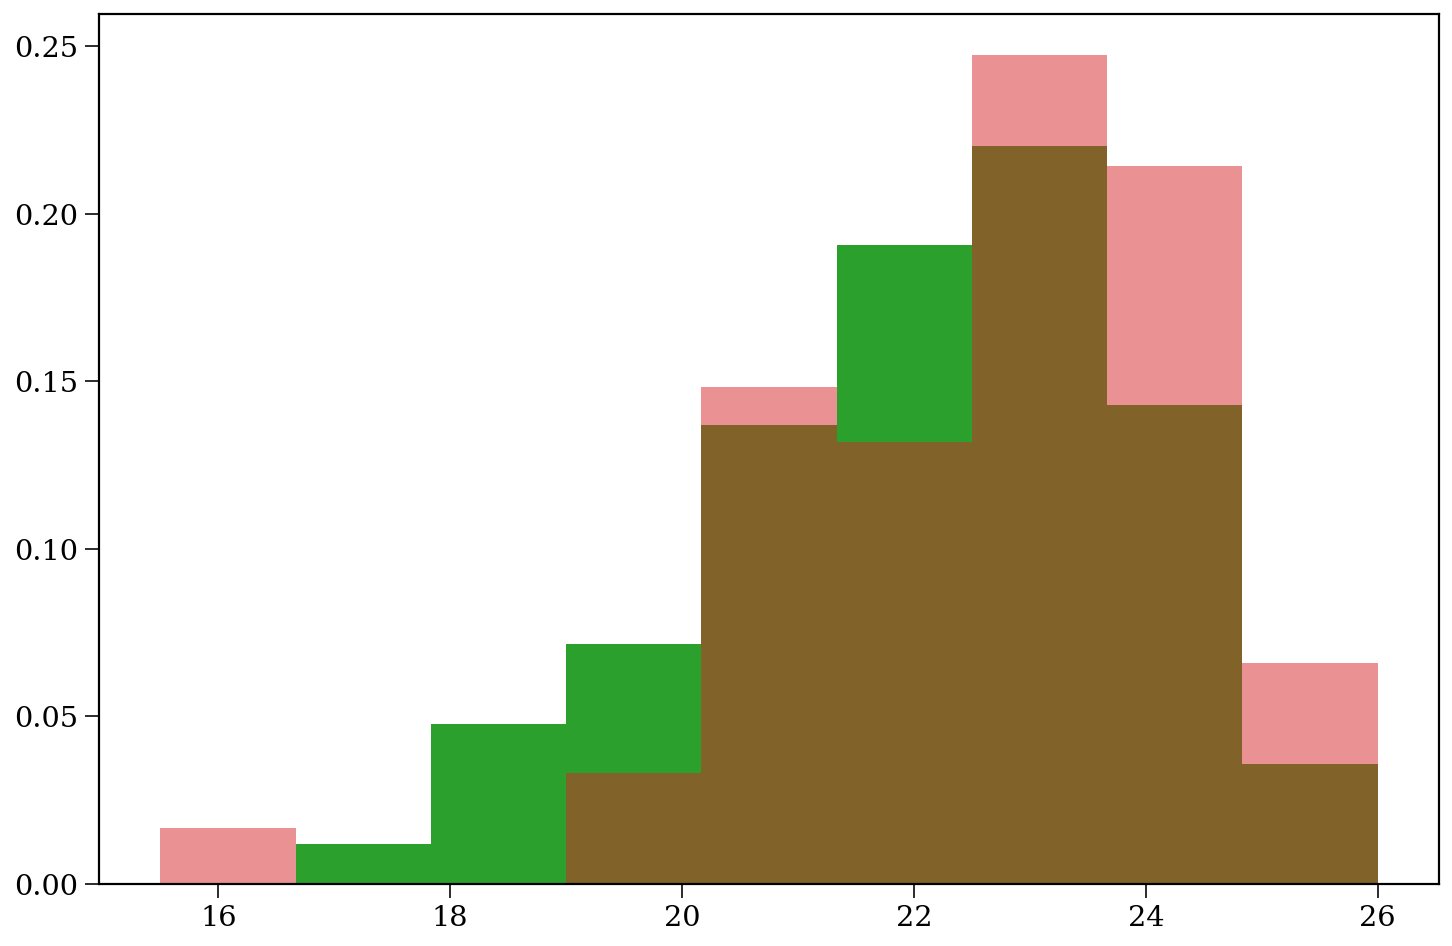

In [295]:
plt.hist(true_params["H"][got_it_right], density=True, cumulative=False, bins=np.linspace(15.5, 26, 10), color="tab:green")
plt.hist(true_params["H"][np.logical_not(got_it_right)], alpha=0.5, density=True, cumulative=False, bins=np.linspace(15.5, 26, 10), color="tab:red")
plt.show()

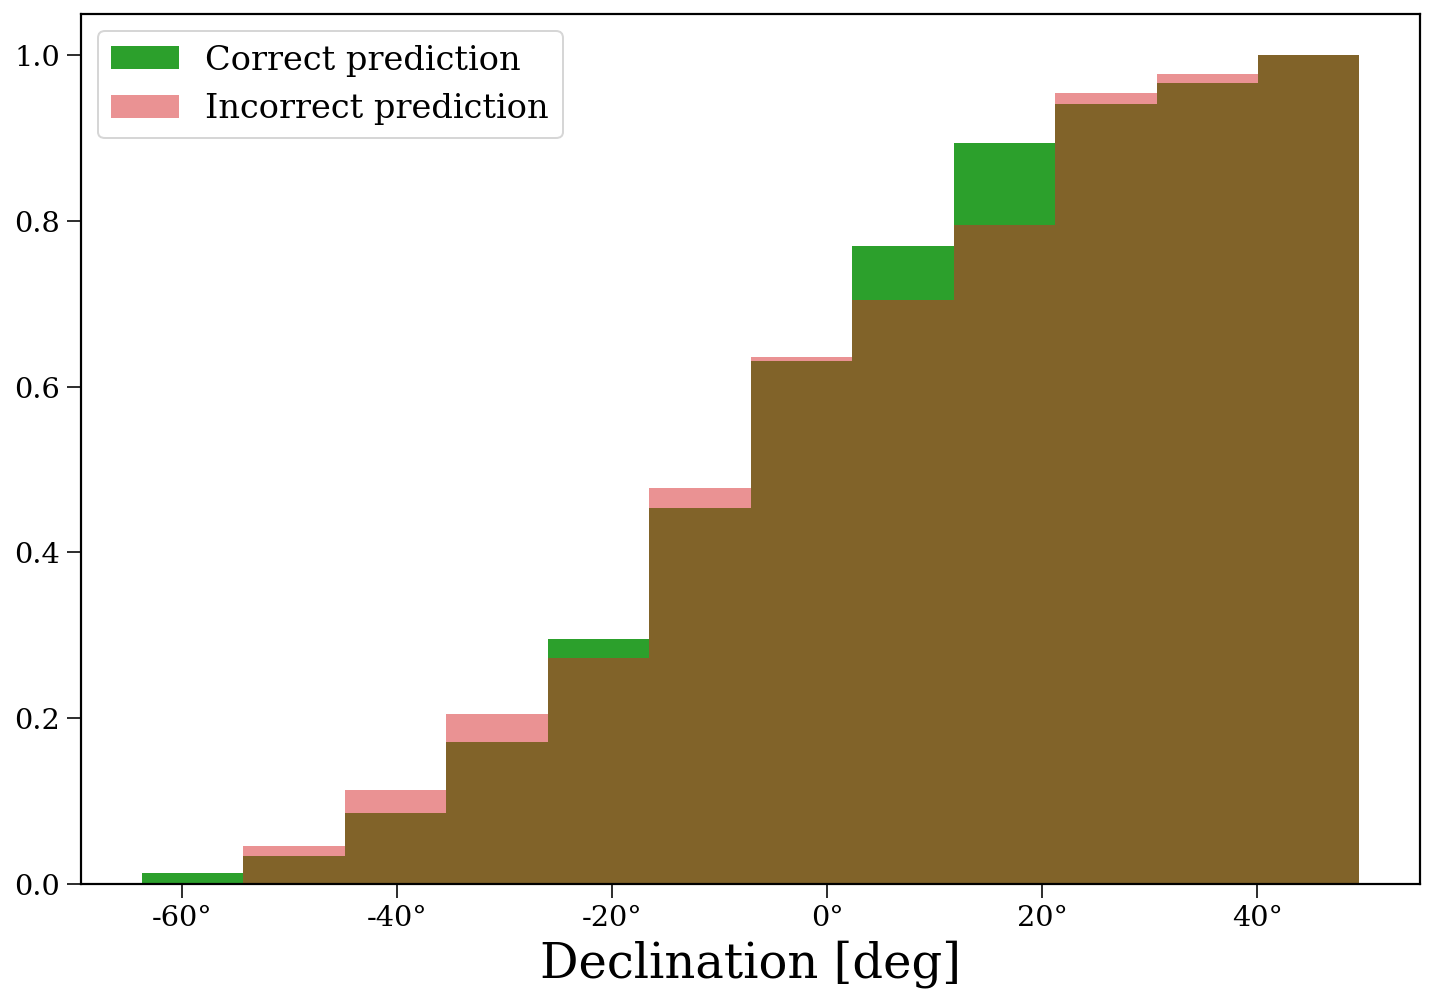

In [89]:
bins = np.linspace(min(sc.transform_to("icrs").dec), max(sc.transform_to("icrs").dec), 13)

plt.hist(sc.transform_to("icrs").dec[got_it_right], density=True, cumulative=True, bins=bins, color="tab:green", label="Correct prediction")
plt.hist(sc.transform_to("icrs").dec[np.logical_not(got_it_right)], alpha=0.5, density=True, cumulative=True, bins=bins, color="tab:red", label="Incorrect prediction")

plt.legend(fontsize=0.7*fs)

plt.xlabel("Declination [deg]")

plt.show()

# Probability of each predicted detection based on orbit fraction

In [229]:
for i in range(10, 25):
    x = joined_table[joined_table["observed"] & (joined_table["night"] == i)]
    print(i)
    print(x.groupby("mjd_utc").count()["orbit_id"] / len(joined_table["orbit_id"].unique()) * 100)
    print()

10
mjd_utc
59649.295709    100.0
59649.296156    100.0
59649.320180    100.0
59649.320627    100.0
Name: orbit_id, dtype: float64

11
mjd_utc
59650.330174    100.000000
59650.351728     99.543379
Name: orbit_id, dtype: float64

12
mjd_utc
59651.250333    1.065449
59651.274791    0.913242
Name: orbit_id, dtype: float64

13
mjd_utc
59652.367719    77.625571
59652.376183     0.456621
59652.377078     6.392694
59652.378861    36.834094
59652.387323     0.608828
59652.388219     6.392694
Name: orbit_id, dtype: float64

14
mjd_utc
59653.244888    1.065449
59653.247818    3.500761
59653.268607    1.065449
59653.271480    3.348554
Name: orbit_id, dtype: float64

15
mjd_utc
59654.240757    8.980213
59654.241222    3.500761
59654.241678    0.608828
59654.242138    1.369863
59654.264676    9.132420
59654.265141    3.500761
59654.265598    0.608828
59654.266058    1.522070
Name: orbit_id, dtype: float64

16
mjd_utc
59655.262812     1.674277
59655.263260     2.435312
59655.263715    26.940639
59655

In [205]:
x = joined_table[joined_table["observed"] & (joined_table["night"] == 18)]
x.groupby("mjd_utc").count()["orbit_id"].values / len(joined_table["orbit_id"].unique()) * 100

array([ 0.15384615,  0.76923077, 36.        , 26.30769231,  8.30769231,
       19.38461538, 10.15384615,  2.61538462,  0.15384615,  0.76923077,
       36.30769231, 26.30769231,  8.30769231, 19.53846154, 10.30769231,
        2.46153846,  0.15384615,  0.76923077, 36.        , 26.30769231,
        8.        , 19.53846154, 10.46153846,  2.46153846,  0.15384615,
        0.76923077, 35.84615385, 26.30769231,  8.        , 19.38461538,
       10.76923077,  2.46153846,  0.76923077, 26.30769231,  8.        ,
       19.23076923, 35.84615385,  0.15384615,  0.76923077, 26.15384615,
        8.        , 19.38461538, 35.69230769,  0.15384615,  0.15384615,
        0.76923077, 35.69230769, 26.15384615,  0.15384615,  1.69230769,
       19.69230769, 10.61538462,  2.30769231,  0.15384615,  0.76923077,
       35.53846154, 26.15384615,  0.15384615,  1.84615385, 19.38461538,
       10.61538462,  2.30769231])

In [304]:
obs_dfs = [pd.read_hdf(path + f"filtered_visit_scores_{i:03d}.h5").sort_values("FieldMJD")
               for i in range(24)]
all_obs = pd.concat(obs_dfs)

time_mask = all_obs["night"] >= night_start
all_obs = all_obs[time_mask]

all_obs["obs_id"] = np.arange(len(all_obs))
all_obs.reset_index(inplace=True)

In [305]:
all_obs

,hex_id,ObjID,night,FieldMJD,AstRA(deg),AstDec(deg),filter,MaginFilter,AstrometricSigma(mas),PhotometricSigma(mag),n_obs,scores,obs_id
0,0002D81,S0000375a,10,59649.208350,158.519607,-21.678267,i,22.695297,28.561714,0.069045,2,99.0,0
1,000756F,S000082pa,10,59649.208350,159.243530,-22.482021,i,23.191904,49.406436,0.121825,2,100.0,1
2,000979F,S0000anGa,10,59649.208350,156.766833,-21.072815,i,20.379974,10.765338,0.010571,4,100.0,2
3,003321F,S0000U1aa,10,59649.208829,155.845105,-26.065509,i,22.082711,18.883869,0.041834,2,100.0,3
4,0007FE1,S00008Kza,10,59649.208829,157.776514,-24.367675,i,23.515696,61.119239,0.149723,2,100.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
236035,00003A1,S00000fqa,377,60016.383717,219.053646,10.663359,y,21.051834,47.484220,0.099880,2,51.0,236035
236036,0000207,S000008Da,377,60016.383717,217.021350,11.143723,y,21.567851,62.038809,0.129902,2,69.0,236036
236037,000162E,S00001w5a,377,60016.385062,224.087428,5.934778,y,21.077982,55.793997,0.108452,6,86.0,236037
236038,000EF87,S0000gp7a,377,60016.385986,227.535324,6.440746,y,21.362047,51.847973,0.111037,2,95.0,236038
